In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
dict_labels = {
    0: 'glioma_tumor',
    1: 'meningioma_tumor',
    2: 'no_tumor',
    3: 'pituitary_tumor'
}

inv_dict_labels = {v: k for k, v in dict_labels.items()}

In [ ]:
def load_images_labels(path):
    images = []
    labels = []

    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            img = cv2.resize(cv2.imread(image_path), (224, 224))
            images.append(img)
            labels.append(label)

    return images, labels

In [ ]:
#para importar las imagenes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_train = ('/content/drive/MyDrive/Colab Notebooks/db/Training/')
path_test = ('/content/drive/MyDrive/Colab Notebooks/db/Testing/')


train_img, train_labels = load_images_labels(path_train)
test_img, test_labels = load_images_labels(path_test)

train_img_1 = np.array(train_img)
train_labels_1 = np.array(train_labels)
test_img_1 = np.array(test_img)
test_labels_1 = np.array(test_labels)

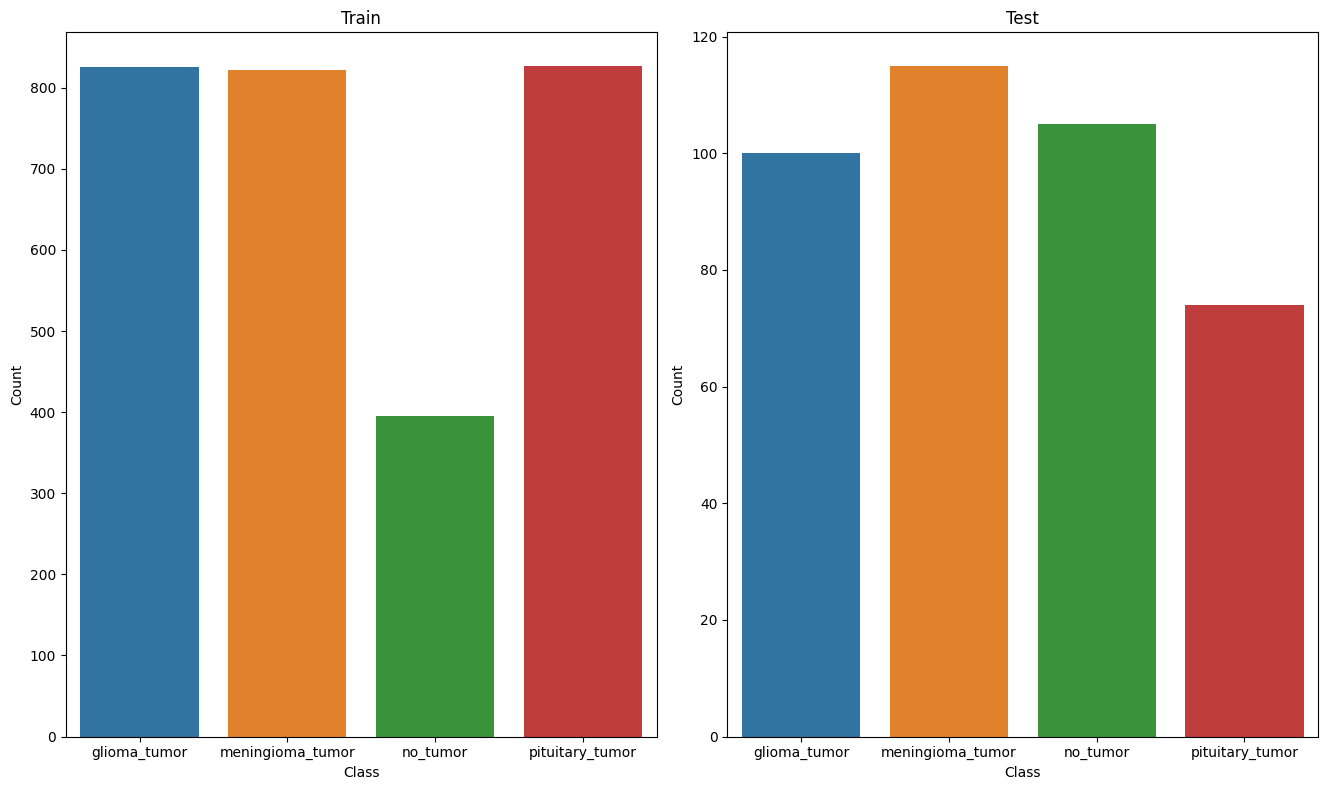

In [ ]:
plt.figure(figsize = (20,8))
lis = ['Train', 'Test']
for i, j in enumerate([train_labels_1, test_labels_1]):
    plt.subplot(1,3,i+1)
    sns.countplot(x = j)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(lis[i])
plt.tight_layout()
plt.show()

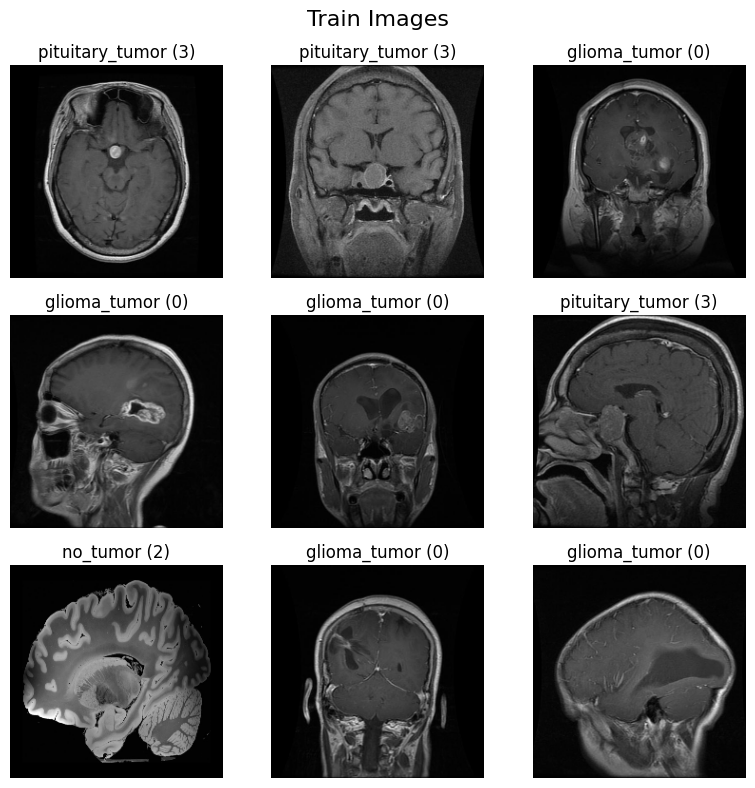

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle('Train Images', fontsize=16)
for i in range(9):
    random_index = np.random.randint(0, len(train_img_1))
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_img_1[random_index])
    plt.title(f'{train_labels_1[random_index]} ({inv_dict_labels[train_labels_1[random_index]]})')
    plt.axis("off")
plt.tight_layout()
plt.show()

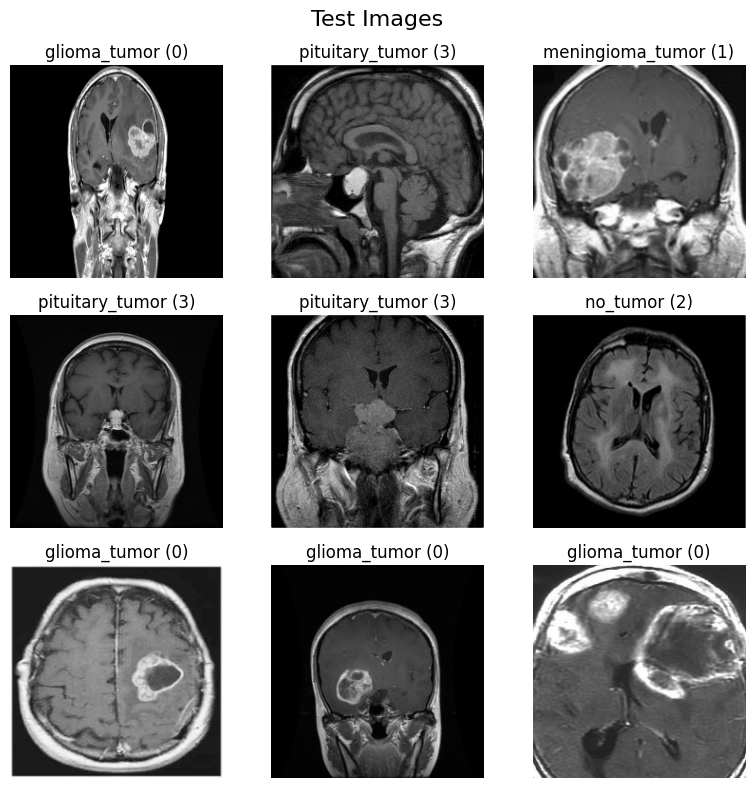

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle('Test Images', fontsize=16)
for i in range(9):
    random_index = np.random.randint(0, len(test_img_1))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img_1[random_index])
    plt.title(f'{test_labels_1[random_index]} ({inv_dict_labels[test_labels_1[random_index]]})')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Juntar los datos de train y test
all_img = np.concatenate((train_img_1, test_img_1))
all_labels = np.concatenate((train_labels_1, test_labels_1))

# Mezclar los datos
all_img, all_labels = shuffle(all_img, all_labels)

# Divide los datos en train y test
train_img, test_img, train_labels, test_labels = train_test_split(all_img, all_labels, test_size=0.12)

# Divide los datos de train en train y validation
train_img, val_img, train_labels, val_labels = train_test_split(train_img, train_labels, test_size=0.1)

In [ ]:
print("train_img.shape: ", train_img.shape, "\ttrain_labels.shape: ", train_labels.shape, "\nval_img.shape: ", val_img.shape, "\tval_labels.shape: ", val_labels.shape, "\ntest_img.shape: ", test_img.shape, "\ttest_labels.shape: ", test_labels.shape)

train_img.shape:  (2584, 224, 224, 3) 	train_labels.shape:  (2584,) 
val_img.shape:  (288, 224, 224, 3) 	val_labels.shape:  (288,) 
test_img.shape:  (392, 224, 224, 3) 	test_labels.shape:  (392,)


In [ ]:
# Normalización de los datos
train_img = train_img.astype('float32') / 255
val_img = val_img.astype('float32') / 255
test_img = test_img.astype('float32') / 255

In [ ]:
# transformamos las etiquetas a numeros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)
test_labels = le.fit_transform(test_labels)

# otra forma de transformar las etiquetas a numeros (one hot encoding)
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

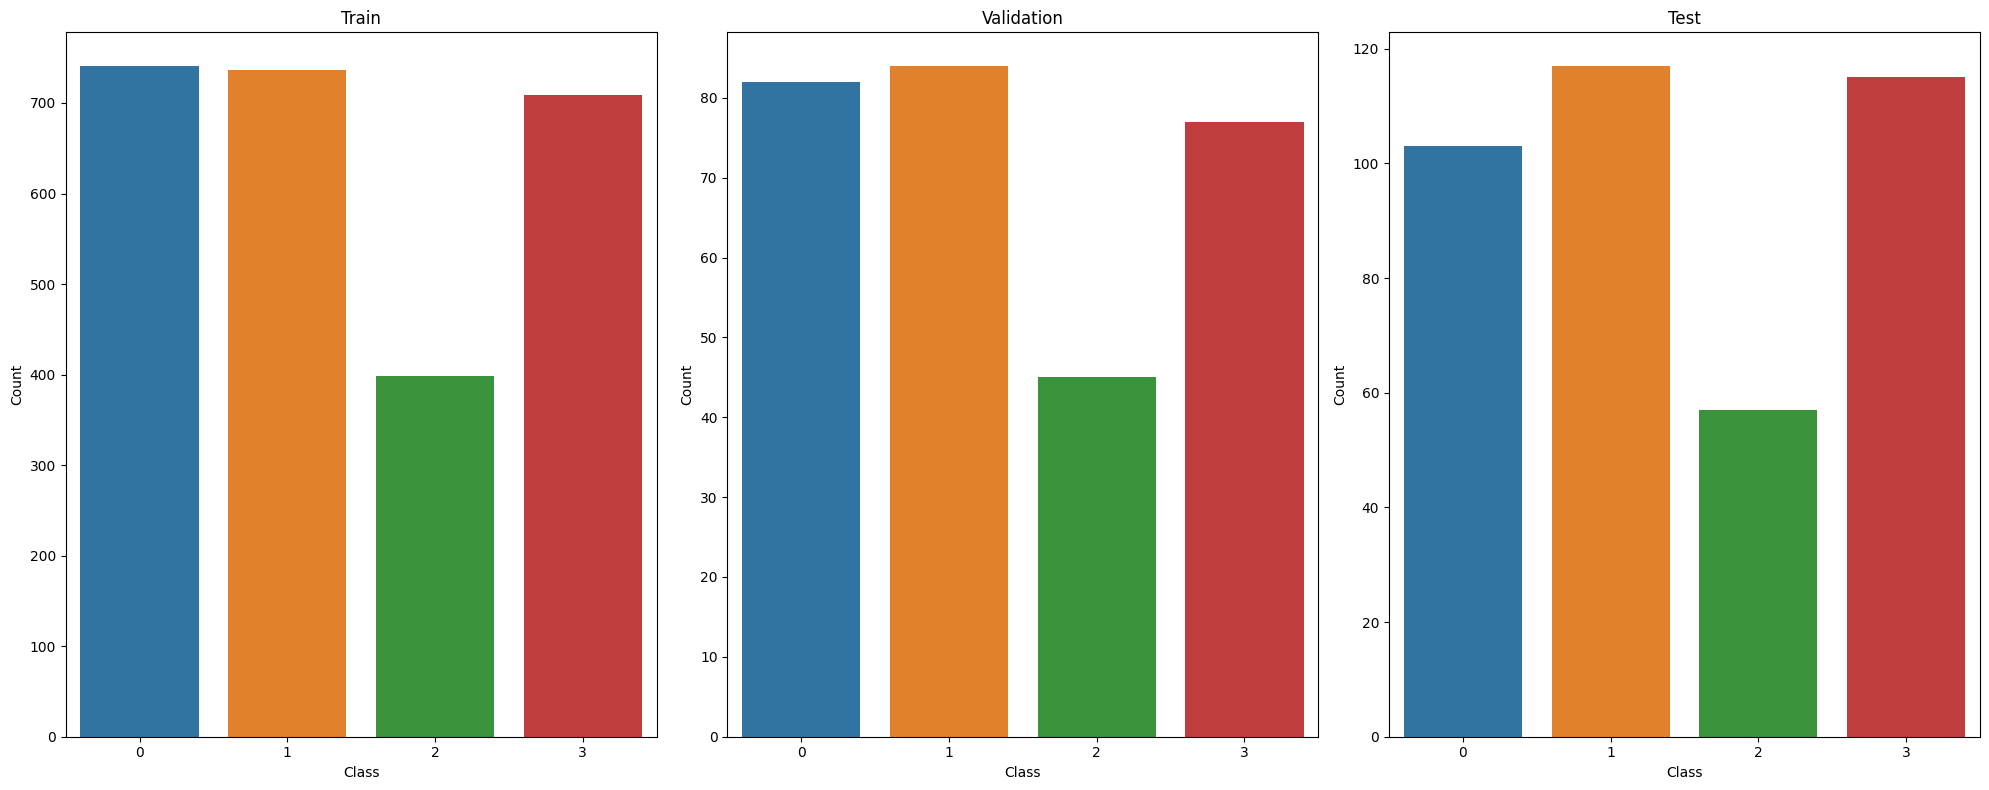

In [ ]:
plt.figure(figsize = (20,8))
lis = ['Train', 'Validation', 'Test']
for i, j in enumerate([train_labels, val_labels, test_labels]):
    plt.subplot(1,3,i+1)
    sns.countplot(x = np.argmax(j, axis=1))
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(lis[i])
plt.tight_layout()
plt.show()

In [ ]:
# Modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=64, activation='relu', padding='same', input_shape=(train_img.shape[1], train_img.shape[2], train_img.shape[3])),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(68, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

In [ ]:
# Entrenamiento
history = model.fit(train_img, train_labels, epochs=200, batch_size = 16, validation_data=(val_img, val_labels), callbacks=[callback])

Epoch 1/200
162/162 [==============================] - 21s 42ms/step - loss: 1.3746 - accuracy: 0.3026 - val_loss: 1.3328 - val_accuracy: 0.4931
Epoch 2/200
162/162 [==============================] - 5s 32ms/step - loss: 1.3348 - accuracy: 0.3344 - val_loss: 1.2548 - val_accuracy: 0.4826
Epoch 3/200
162/162 [==============================] - 5s 33ms/step - loss: 1.2785 - accuracy: 0.3800 - val_loss: 1.2168 - val_accuracy: 0.4861
Epoch 4/200
162/162 [==============================] - 6s 35ms/step - loss: 1.2086 - accuracy: 0.4226 - val_loss: 1.0354 - val_accuracy: 0.5104
Epoch 5/200
162/162 [==============================] - 5s 32ms/step - loss: 1.1144 - accuracy: 0.4516 - val_loss: 0.9457 - val_accuracy: 0.5139
Epoch 6/200
162/162 [==============================] - 5s 33ms/step - loss: 1.1032 - accuracy: 0.4594 - val_loss: 0.8656 - val_accuracy: 0.5347
Epoch 7/200
162/162 [==============================] - 6s 36ms/step - loss: 1.0338 - accuracy: 0.4868 - val_loss: 0.8418 - val_accuracy

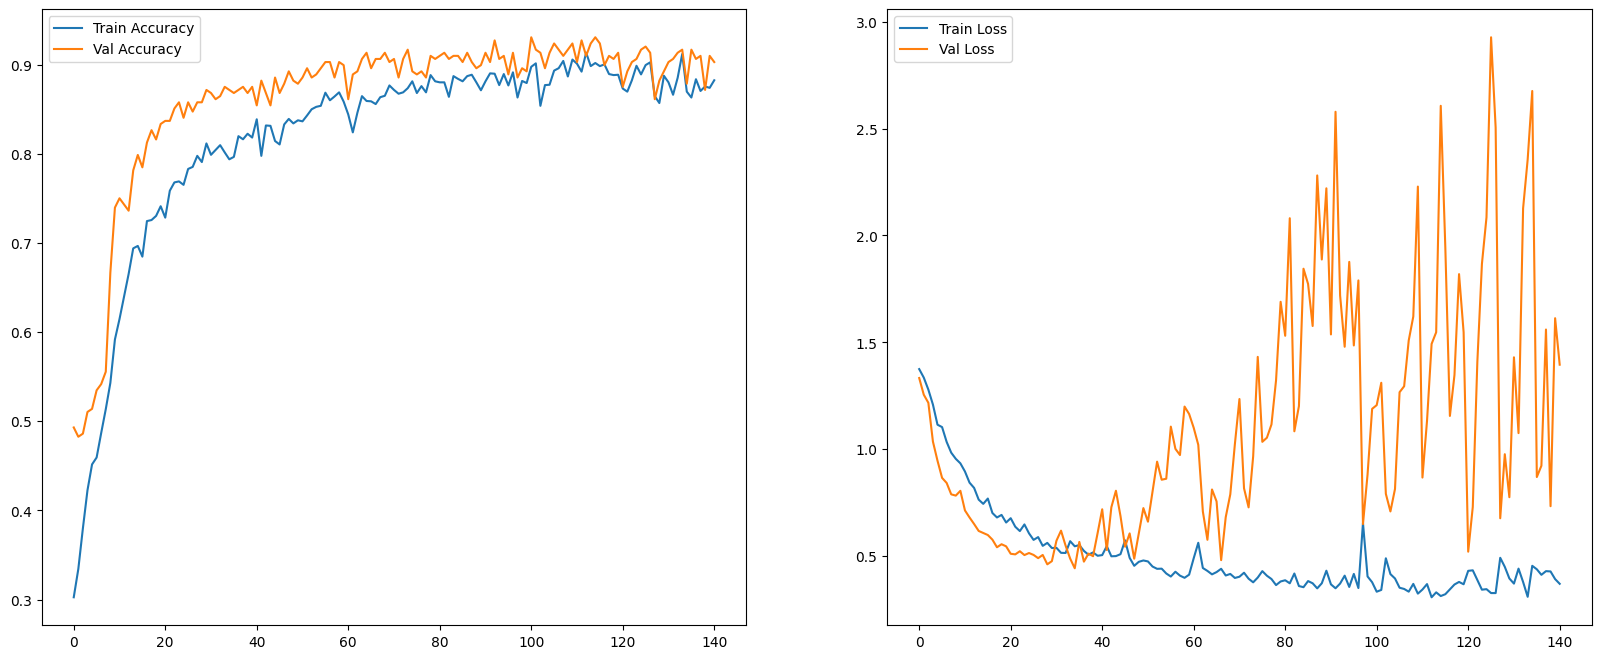

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_img)

13/13 [==============================] - 1s 17ms/step


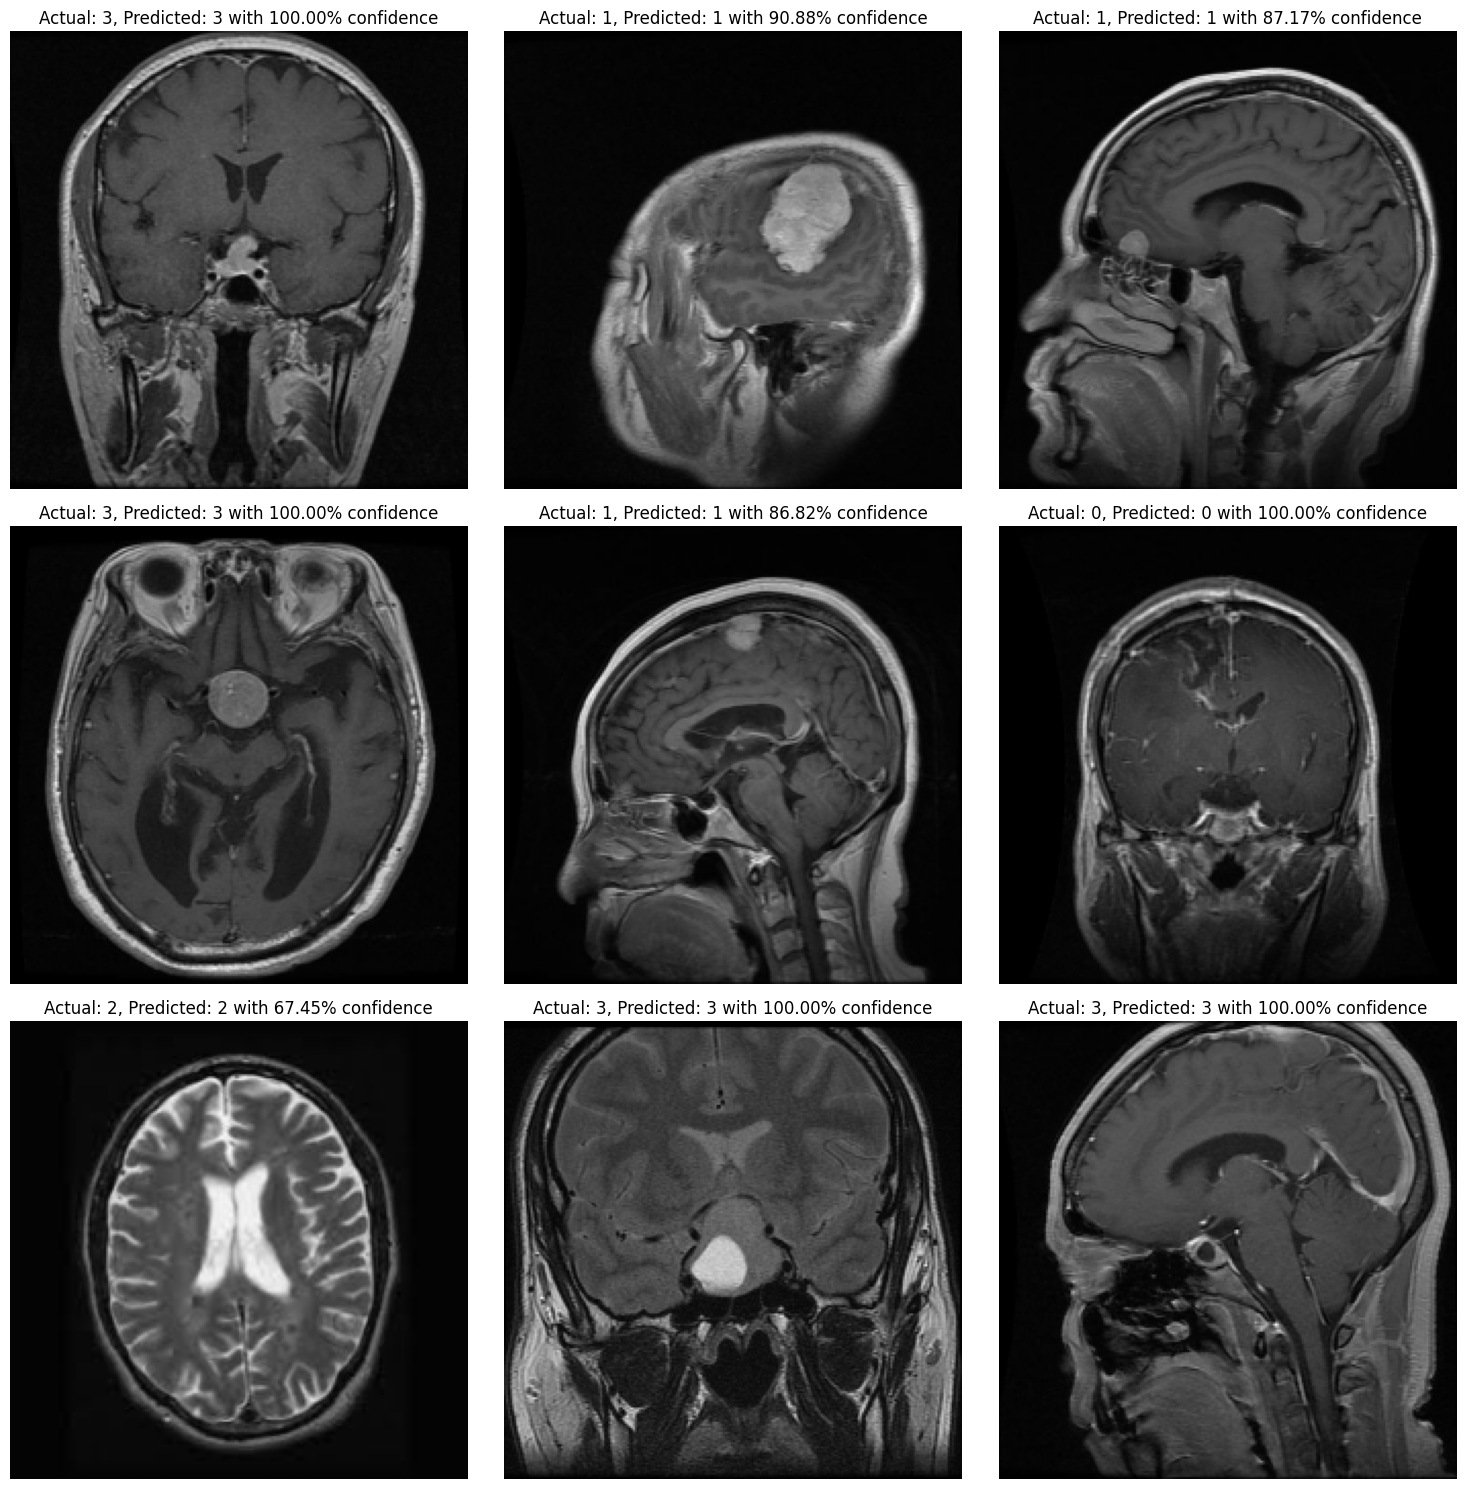

In [ ]:
# Comprobación de las predicciones
plt.figure(figsize=(15,15))
for i in range(9):
    random_index = np.random.randint(0, len(test_img))
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_img[random_index])
    actual_label = np.argmax(test_labels[random_index])
    predicted_label = np.argmax(predictions[random_index])
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label} with {np.max(predictions[random_index]) * 100:.2f}% confidence')
    plt.axis("off")
plt.tight_layout()
plt.show()

Accuracy Score:  0.8877551020408163


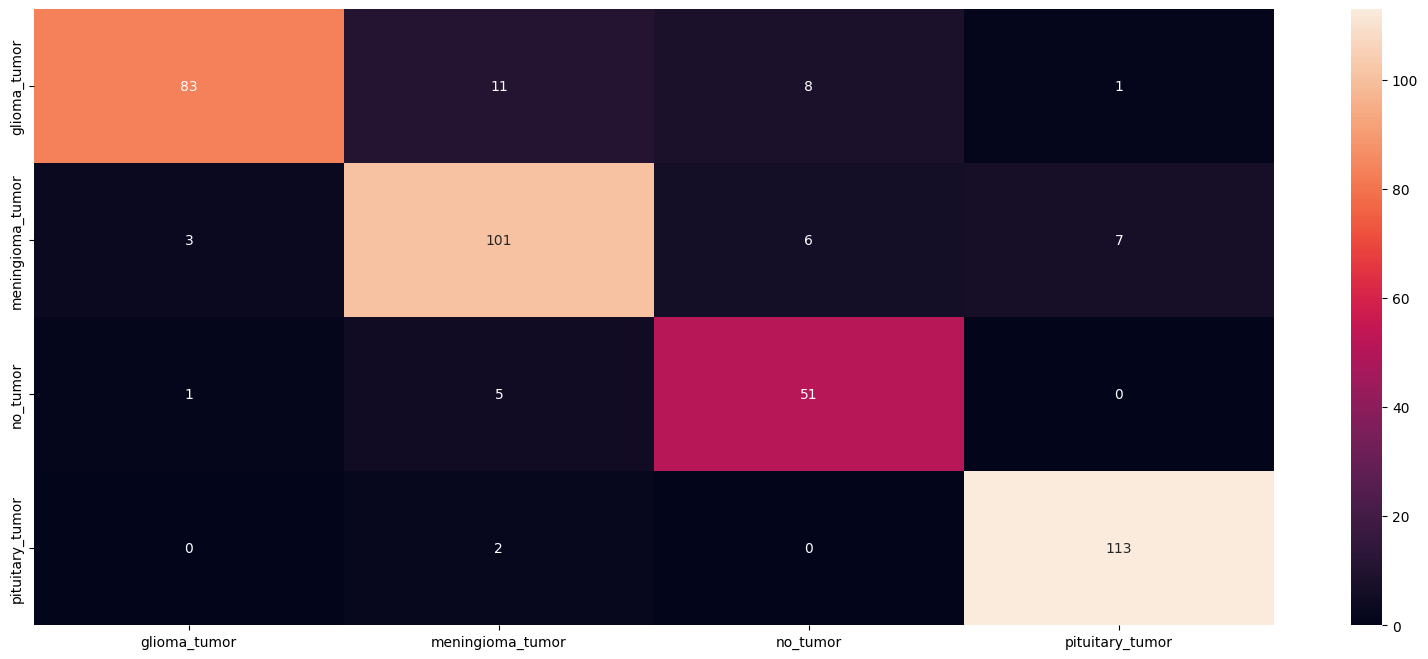

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_labels_class = np.argmax(test_labels, axis=1)
predictions_class = np.argmax(predictions, axis=1)
print("Accuracy Score: ", accuracy_score(test_labels_class, predictions_class))
plt.figure(figsize=(20,8))
sns.heatmap(confusion_matrix(test_labels_class, predictions_class), annot=True, fmt='g', xticklabels=dict_labels.values(), yticklabels=dict_labels.values())
plt.show()